# Assessing State-Level Disparities in Pesticide Safety Enforcement: A Data-Driven Approach to Farmworker Risk

## Problem Statement and Background
    Pesticide exposure poses serious health risks to agricultural workers, including respiratory issues, neurological disorders, and chronic illnesses. To mitigate these risks, the U.S. Environmental Protection Agency (EPA) established the Worker Protection Standard (WPS). However, enforcement of the WPS varies across states, leading to unequal protection and persistent exposure risks in high-risk regions.

    This project investigates whether some states fail to adequately protect farmworkers due to lax inspections and limited penalties for WPS violations. It focuses on identifying states with high reliance on pesticide use and agricultural labor but weak enforcement—highlighting concerns of environmental justice and regulatory inequality.

    Motivated by the need to protect a vulnerable labor force essential to the U.S. food system, the study integrates data on pesticide usage, WPS violations, and farm labor to examine the relationship between enforcement rigor and exposure risk. The goal is to pinpoint states where farmworkers are most at risk and to inform more effective, data-driven policy and inspection strategies.

    Identifying high-risk states can help agencies allocate resources more strategically, support advocacy for farmworker rights, and draw attention to areas lacking adequate environmental health protections—ultimately contributing to a more equitable and accountable agricultural system.

## Normalization:
    To prepare for clustering and regression analysis, we applied Z-score standardization to four key variables: WPS violations, inspections, pesticide applied acreage, and hired farm labor. This transformation re-scaled each variable to a mean of 0 and standard deviation of 1, ensuring equal contribution to the analysis. For instance, pesticide-treated acreage ranged from under 20,000 acres in Alaska to over 35 million in California, while most states reported fewer than 100 violations. Normalization prevented any single variable from dominating due to scale differences, enabling fair comparisons across states.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

In [2]:
# Update your database info if needed
engine = create_engine("mysql+pymysql://root:@localhost:3306/wps_db")

In [3]:
# Load the merged dataset from MySQL
df = pd.read_sql("SELECT * FROM merged_analysis_data", con=engine)
df.head()

,state,num_inspections,year,num_violations,Pesticide_applied_acreage,hired_farm_labor
0,ALABAMA,107.0,2012,20.0,3590086,32948
1,ALABAMA,153.0,2017,12.0,3736145,26136
2,ALASKA,6.0,2012,6.0,16066,1577
3,ALASKA,4.0,2017,4.0,11591,1988
4,ARIZONA,116.0,2012,6.0,1526823,29245


In [4]:
# Columns to normalize
features_to_normalize = [
    "num_violations",
    "num_inspections",
    "Pesticide_applied_acreage",
    "hired_farm_labor"
]

# Apply StandardScaler
scaler = StandardScaler()
normalized_values = scaler.fit_transform(df[features_to_normalize])

# Add normalized columns
normalized_column_names = [f"{col}_zscore" for col in features_to_normalize]
df[normalized_column_names] = normalized_values

In [5]:
# Upload normalized dataframe to MySQL
df.to_sql("normalized_analysis_data", con=engine, if_exists="replace", index=False)
print("normalized_analysis_data table uploaded to MySQL.")

normalized_analysis_data table uploaded to MySQL.


In [6]:
# Preview normalized table from MySQL
pd.read_sql("SELECT * FROM normalized_analysis_data LIMIT 5", con=engine)

,state,num_inspections,year,num_violations,Pesticide_applied_acreage,hired_farm_labor,num_violations_zscore,num_inspections_zscore,Pesticide_applied_acreage_zscore,hired_farm_labor_zscore
0,ALABAMA,107.0,2012,20.0,3590086,32948,-0.147984,0.323857,-0.547841,-0.285904
1,ALABAMA,153.0,2017,12.0,3736145,26136,-0.228497,0.708965,-0.533484,-0.386481
2,ALASKA,6.0,2012,6.0,16066,1577,-0.288882,-0.521708,-0.899166,-0.749088
3,ALASKA,4.0,2017,4.0,11591,1988,-0.309010,-0.538452,-0.899606,-0.743019
4,ARIZONA,116.0,2012,6.0,1526823,29245,-0.288882,0.399204,-0.750659,-0.340578


## Farmworker Exposure Risk Index (FERI)

To quantify and compare pesticide exposure risk across U.S. states, we developed the **Farmworker Exposure Risk Index (FERI)** — a composite metric designed to reflect both **chemical intensity** and **enforcement effectiveness**. 

FERI is defined as:

$$
\text{FERI} = \alpha \cdot \left( \frac{\text{Pesticide Applied Acreage}}{\text{Hired Farm Labor}} \right) + \beta \cdot \left( \frac{\text{WPS Violations}}{\text{Inspections}} \right)
$$

where the first term reflects **chemical exposure per worker**, and the second term captures **violations per inspection**, a proxy for enforcement rigor.

In this analysis, $\alpha$ and $\beta$ were set to **0.5**, assigning equal weight to each component to ensure a **balanced risk assessment**.

This formulation allows both **high exposure intensity** and **low enforcement** to weigh equally in FERI, enabling more meaningful state comparisons. 

In [7]:
# Load the merged dataset
df = pd.read_csv("../merge/merged_analysis_data.csv")  # Update with your actual file path

In [8]:
# Ensure numeric types for calculation
df["num_violations"] = pd.to_numeric(df["num_violations"], errors="coerce")
df["num_inspections"] = pd.to_numeric(df["num_inspections"], errors="coerce")
df["Pesticide_applied_acreage"] = pd.to_numeric(df["Pesticide_applied_acreage"], errors="coerce")
df["hired_farm_labor"] = pd.to_numeric(df["hired_farm_labor"], errors="coerce")

In [9]:
# Calculate pesticide exposure per worker and violations per inspection
df["violations_per_inspection"] = df["num_violations"] / df["num_inspections"]
df["pesticide_per_worker"] = df["Pesticide_applied_acreage"] / df["hired_farm_labor"]

In [10]:
# Drop rows with missing or invalid metrics
df = df.dropna(subset=["violations_per_inspection", "pesticide_per_worker"])

In [11]:
# Define weights
alpha = 0.5
beta = 0.5

# Compute FERI
df["FERI"] = (alpha * df["pesticide_per_worker"]) + (beta * df["violations_per_inspection"])

In [12]:
# Save results to CSV and show top 10 states by FERI
df.to_csv("feri_index_results.csv", index=False)
df[["state", "year", "FERI"]].sort_values("FERI", ascending=False).head(10)

,state,year,FERI
67,NORTH DAKOTA,2017,674.043367
66,NORTH DAKOTA,2012,588.614551
81,SOUTH DAKOTA,2017,386.497550
80,SOUTH DAKOTA,2012,358.490663
31,KANSAS,2017,339.561772
25,ILLINOIS,2017,314.668689
53,NEBRASKA,2017,309.161371
51,MONTANA,2017,294.522454
30,KANSAS,2012,282.310427
24,ILLINOIS,2012,264.635996


### Visualization
States like **North Dakota (2017)**, **South Dakota (2012 & 2017)**, and **Kansas (2017)** ranked highest despite low violation counts, due to **sparse inspections** and **high pesticide use per worker** — demonstrating FERI’s ability to reveal hidden risks.

In contrast, **California**, with high violation reports, received a **lower FERI score** due to **stronger enforcement** and a **larger labor force**, which reduced per-worker exposure risk.

Overall, FERI serves as a **policy-relevant tool** to identify high-risk states that may be overlooked by raw violation data, supporting more **targeted inspections** and **equitable enforcement**.

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import us

In [14]:
# Load computed FERI scores
feri_df = pd.read_csv("feri_index_results.csv")
feri_df["state"] = feri_df["state"].str.upper()  # Ensure consistent case for joining

In [15]:
# Load U.S. states geometry file (GeoJSON or shapefile)
states_gdf = gpd.read_file("FERI/us-states1.json")
states_gdf["name"] = states_gdf["name"].str.upper()

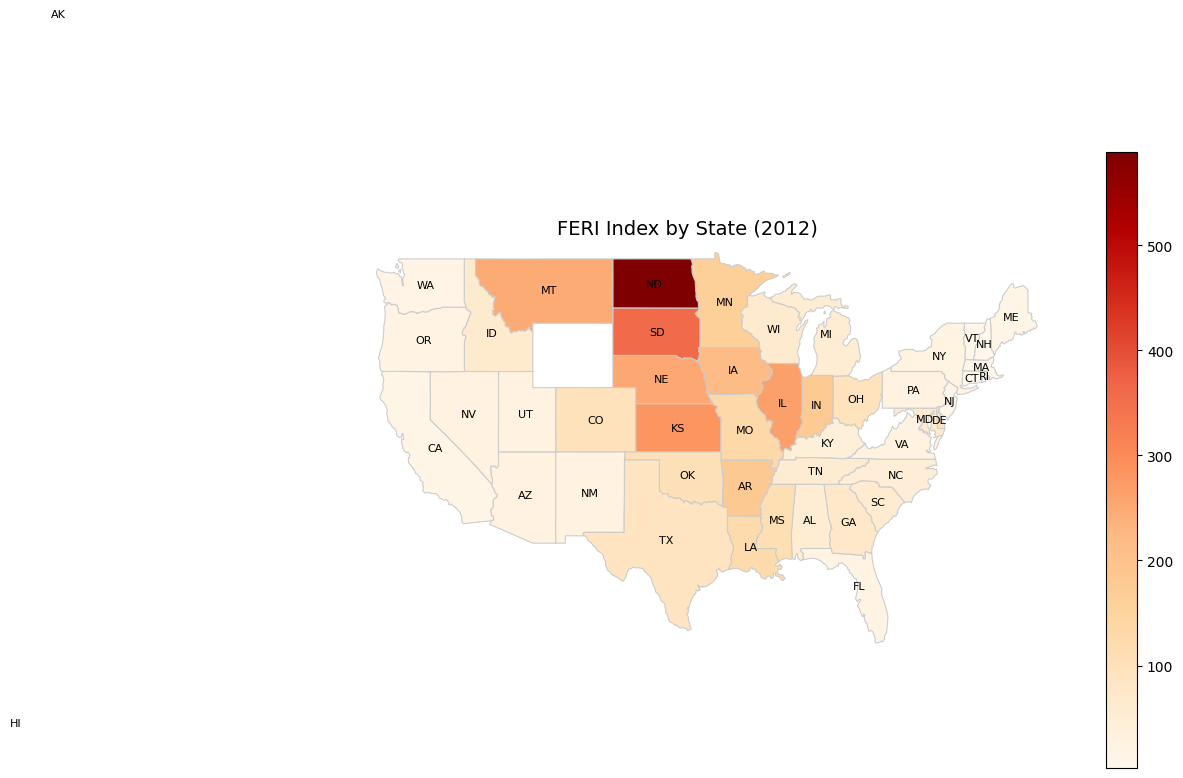

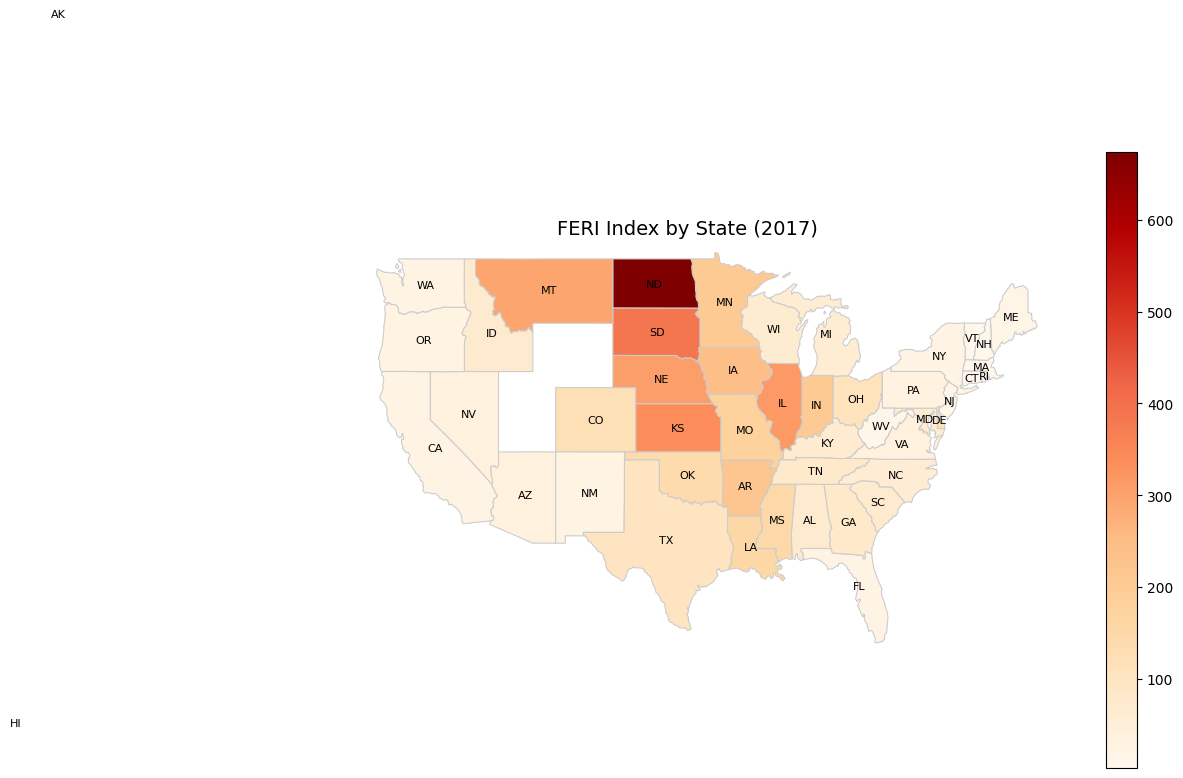

In [16]:
# Loop through selected years
for year in [2012, 2017]:
    # Filter dataset for current year
    feri_year = feri_df[feri_df["year"] == year]

    # Merge spatial data with FERI values
    merged = states_gdf.merge(feri_year, left_on="name", right_on="state", how="left")

    # Add state abbreviations
    merged["state_abbr"] = merged["state"].apply(
        lambda x: us.states.lookup(str(x)).abbr if pd.notnull(x) and us.states.lookup(str(x)) else ""
    )

    # === Plot heatmap ===
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    merged.plot(
        column="FERI",
        cmap="OrRd",
        linewidth=0.8,
        ax=ax,
        edgecolor="0.8",
        legend=True
    )

    ax.set_title(f"FERI Index by State ({year})", fontsize=14)
    ax.axis("off")
    ax.set_xlim(-130, -65)  # Focus on continental U.S.
    ax.set_ylim(23, 50)

    # Add state abbreviation labels
    for idx, row in merged.iterrows():
        if row["geometry"].centroid.is_empty or pd.isna(row["FERI"]):
            continue
        x, y = row["geometry"].centroid.x, row["geometry"].centroid.y
        ax.text(x, y, row["state_abbr"], fontsize=8, ha='center', va='center', color='black')

    # Save and display the map
    plt.savefig(f"feri_heatmap_{year}_abbr_labeled.png", dpi=300)
    plt.show()

### K-Mean Clustering:

To better assess farmworker pesticide exposure risks across U.S. states, we applied K-Means clustering to group state-year observations into risk tiers. Unlike traditional methods based on raw violation counts or pesticide use alone, this unsupervised approach integrates multiple standardized indicators to improve interpretability and policy relevance.

Clustering was based on three variables:  
(1) the Farmworker Exposure Risk Index (FERI), capturing both exposure intensity and regulatory weakness;  
(2) pesticide use per worker; and  
(3) violations per inspection.  

All variables were standardized using Z-scores to ensure equal weight in the clustering process.

The clustering model used **K = 3**, grouping states into **high- (Cluster 0)**, **medium- (Cluster 1)**, and **low-risk (Cluster 2)** categories. High-risk states typically had high FERI scores, low inspection rates, and intensive pesticide use.

In [17]:
# Load necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load FERI dataset
df = pd.read_csv("FERI/feri_index_results.csv")  # Update this path as needed

# Drop rows with missing values in required columns
df = df.dropna(subset=["FERI", "Pesticide_applied_acreage", "hired_farm_labor", "num_violations", "num_inspections"])

In [18]:
# Calculate ratio-based indicators
df["pesticide_per_worker"] = df["Pesticide_applied_acreage"] / df["hired_farm_labor"]
df["violations_per_inspection"] = df["num_violations"] / df["num_inspections"]

# Select features for clustering
features = ["FERI", "pesticide_per_worker", "violations_per_inspection"]
X = df[features]

# Standardize features (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering (K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

In [19]:
# Save results or preview top results
df.to_csv("feri_clustered_results.csv", index=False)
df[["state", "year", "FERI", "cluster"]].sort_values("cluster").head(10)

,state,year,FERI,cluster
0,ALABAMA,2012,54.574549,0
65,NORTH CAROLINA,2017,59.445005,0
64,NORTH CAROLINA,2012,47.688908,0
63,NEW YORK,2017,25.432905,0
62,NEW YORK,2012,25.255381,0
61,NEW MEXICO,2017,27.331835,0
60,NEW MEXICO,2012,25.928450,0
59,NEW JERSEY,2017,10.820485,0
58,NEW JERSEY,2012,11.329671,0
57,NEW HAMPSHIRE,2017,2.462231,0


## Visualization
Low-risk states showed strong oversight and lower pesticide intensity, while medium-risk states held intermediate profiles. To improve interpretability, heatmaps were generated, where color depth reflects violation density.

States were sorted by year on the Y-axis and cluster assignment on the X-axis. The gradient display revealed clear intra-cluster patterns, enhancing the clarity and policy utility of the clustering results.

Notably North Dakota and Kansas, which ranked high despite reporting few violations, revealing hidden risks tied to weak enforcement.

In [20]:
import seaborn as sns

# Load clustered FERI dataset
df = pd.read_csv("feri_clustered_results.csv")

# Create a 'state_year' label for visualization
df["state_year"] = df["state"] + " (" + df["year"].astype(str) + ")"

In [21]:
# Split into 2012 and 2017 datasets
heatmap_2012 = df[df["year"] == 2012].copy()
heatmap_2017 = df[df["year"] == 2017].copy()

In [22]:
# Sort states within each cluster by violations_per_inspection (descending)
# Cluster order: Cluster 2 (Low Risk) → Cluster 1 (Medium) → Cluster 0 (High Risk)
ordered_2012 = pd.concat([
    heatmap_2012[heatmap_2012["cluster"] == c].sort_values(by="violations_per_inspection", ascending=False)
    for c in [2, 1, 0]
])
ordered_2017 = pd.concat([
    heatmap_2017[heatmap_2017["cluster"] == c].sort_values(by="violations_per_inspection", ascending=False)
    for c in [2, 1, 0]
])

In [23]:
# Create pivot tables (rows = state-year, columns = cluster, values = violations per inspection)
pivot_2012 = ordered_2012.pivot_table(
    index="state_year", columns="cluster", values="violations_per_inspection", fill_value=0
)
pivot_2012 = pivot_2012.reindex(index=ordered_2012["state_year"])
pivot_2012 = pivot_2012.reindex(columns=[0, 1, 2], fill_value=0)  # Ensure all clusters appear

pivot_2017 = ordered_2017.pivot_table(
    index="state_year", columns="cluster", values="violations_per_inspection", fill_value=0
)
pivot_2017 = pivot_2017.reindex(index=ordered_2017["state_year"])
pivot_2017 = pivot_2017.reindex(columns=[0, 1, 2], fill_value=0)

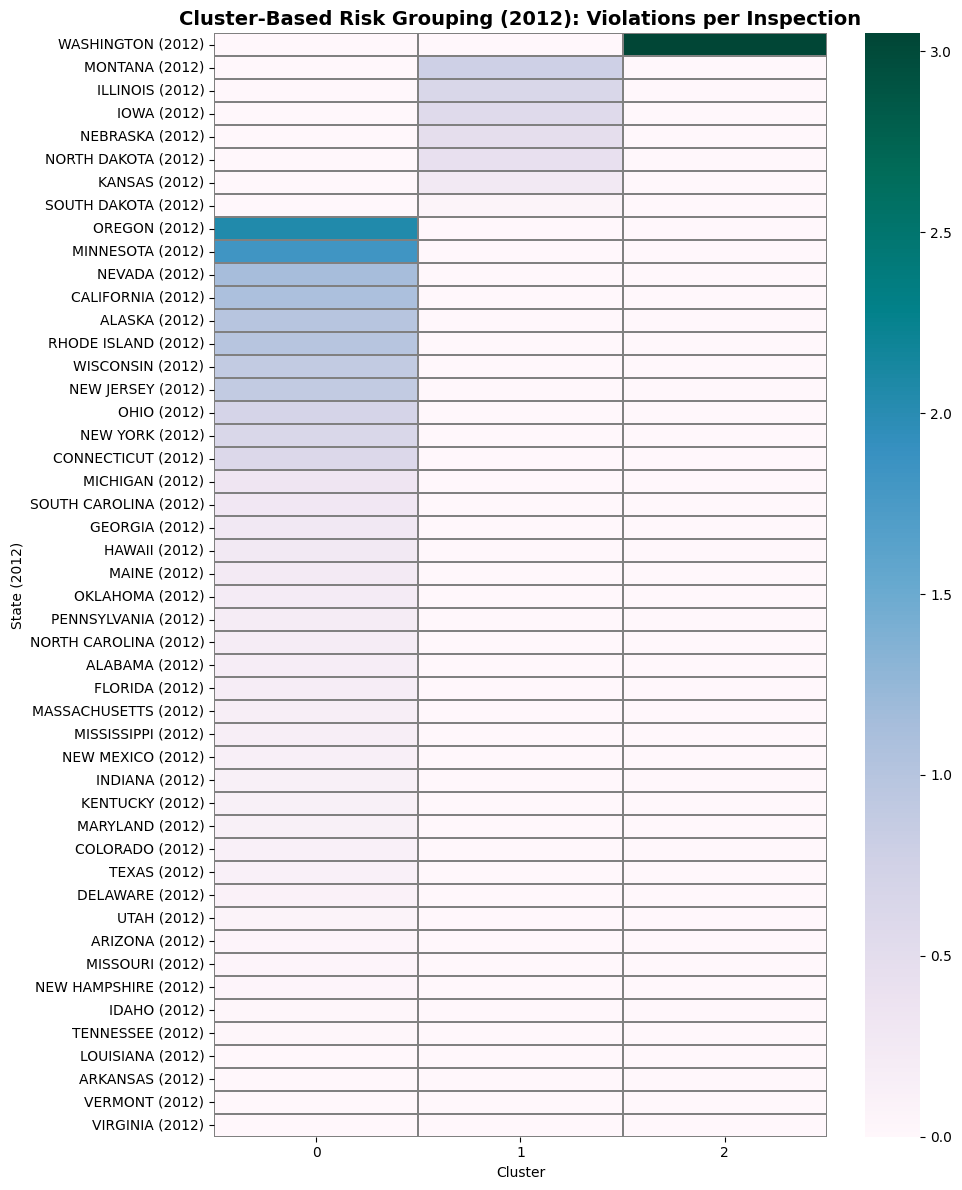

In [24]:
# Plot heatmap for 2012
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_2012, cmap="PuBuGn", linewidths=0.3, linecolor='gray')
plt.title("Cluster-Based Risk Grouping (2012): Violations per Inspection", fontsize=14, weight='bold')
plt.xlabel("Cluster")
plt.ylabel("State (2012)")
plt.tight_layout()
plt.savefig("viol_per_insp_heatmap_2012_cluster_emphasis.png")
plt.show()

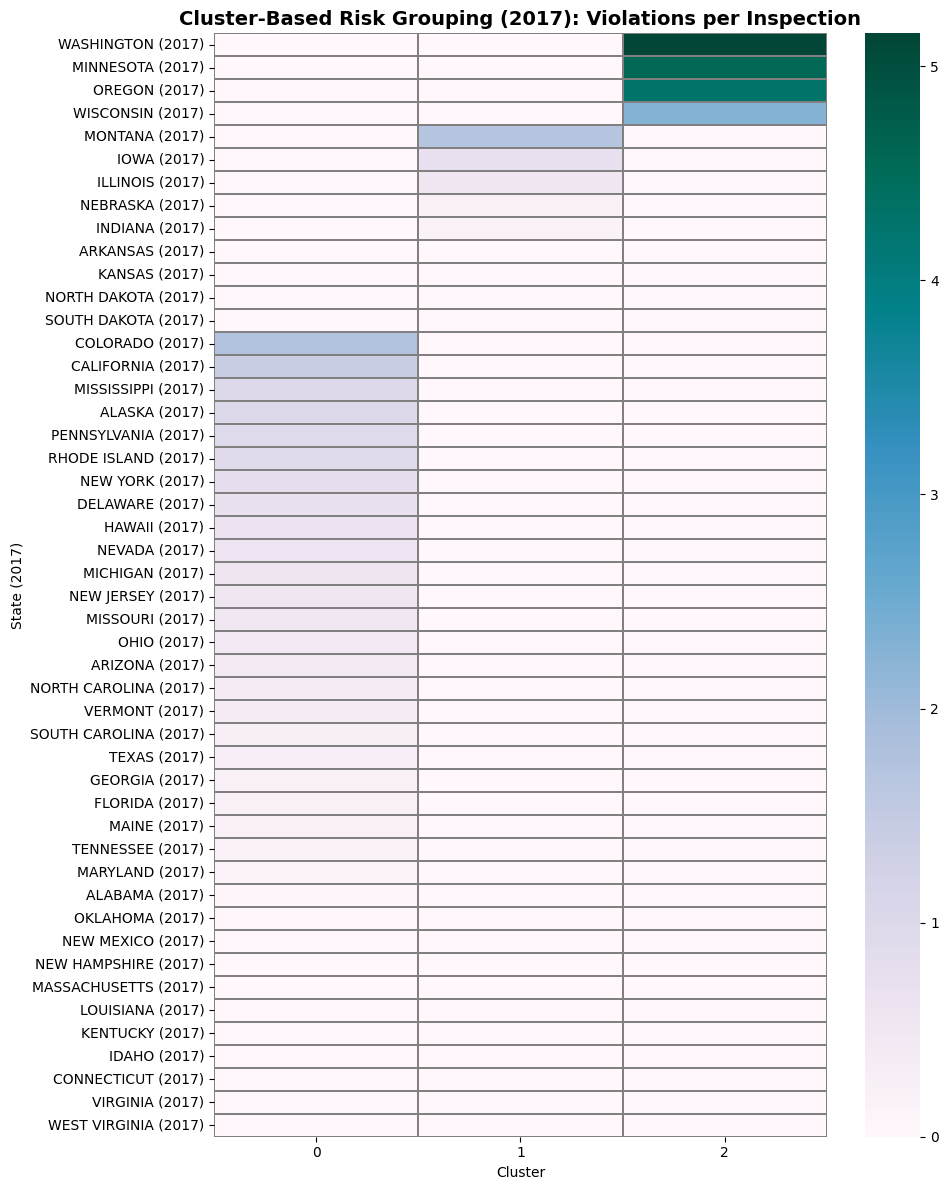

In [25]:
# Plot heatmap for 2017
plt.figure(figsize=(10, 12))
sns.heatmap(pivot_2017, cmap="PuBuGn", linewidths=0.3, linecolor='gray')
plt.title("Cluster-Based Risk Grouping (2017): Violations per Inspection", fontsize=14, weight='bold')
plt.xlabel("Cluster")
plt.ylabel("State (2017)")
plt.tight_layout()
plt.savefig("viol_per_insp_heatmap_2017_cluster_emphasis.png")
plt.show()

### **Predictive Regression Modeling - Estimating WPS Violations**

To assess whether structural factors could predict WPS violations, we built a multiple linear regression model using three standardized predictors:

- Pesticide acreage  
- Hired farm labor  
- Number of inspections  

Data was split 80/20 for training and testing, and fitted using OLS regression with Z-score normalization.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Load and clean data
df = pd.read_csv("cluster/feri_clustered_results.csv")
df = df.dropna(subset=["Pesticide_applied_acreage", "hired_farm_labor", "num_inspections", "num_violations"])

In [27]:
# Define features and target
X = df[["Pesticide_applied_acreage", "hired_farm_labor", "num_inspections"]]
y = df["num_violations"]

In [28]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:
# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

In [31]:
# Output results
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
print("R² Score:", r2)
print("Mean Squared Error:", mse)

Intercept: -2.305408967306356
Coefficients: [1.28174860e-07 1.46866907e-04 4.76837343e-01]
R² Score: -1.7234580105457558
Mean Squared Error: 1600.4332912521875


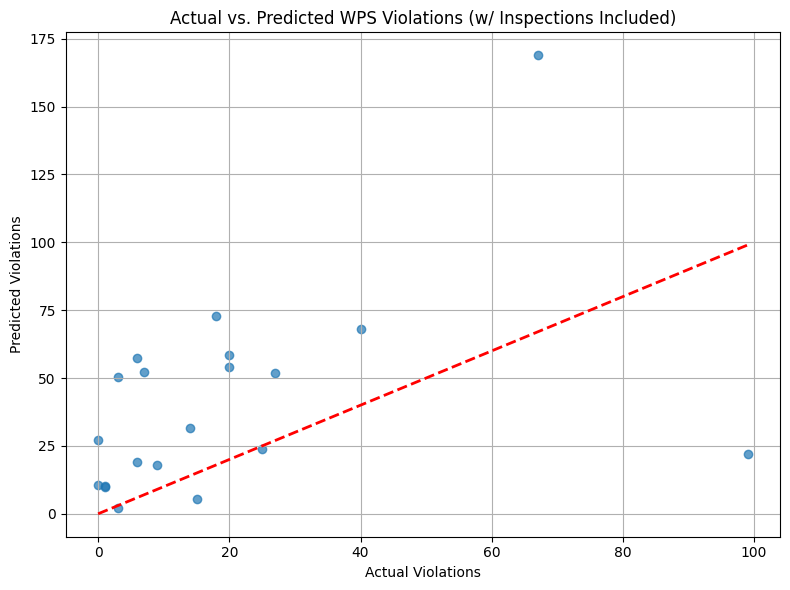

In [32]:
# Plot actual vs. predicted violations
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
plt.xlabel("Actual Violations")
plt.ylabel("Predicted Violations")
plt.title("Actual vs. Predicted WPS Violations (w/ Inspections Included)")
plt.grid(True)
plt.tight_layout()
plt.savefig("actual_vs_predicted_violations_with_inspections.png")
plt.show()

### Analysis
**Inspections** emerged as the strongest predictor (coefficient = **0.48**), while **pesticide acreage** (**1.28e−07**) and **labor** (**0.00015**) showed minimal impact.

However, the model performed poorly:  
- $R^2 = -1.72$  
- MSE = 1600.43  

This suggests that violations are driven more by **enforcement visibility** than by agricultural scale.

Despite low accuracy, the model supports findings from FERI and clustering, emphasizing the need for **multidimensional approaches** to uncover underreported risk.

### 4. Results and Conclusions

This study assessed farmworker pesticide exposure risk across U.S. states (2011–2021) by integrating data on agricultural intensity, labor size, and enforcement activity. Using exploratory analysis, risk indexing (FERI), clustering, and regression modeling, we developed a multi-dimensional framework to uncover structural drivers of WPS (Worker Protection Standard) violations.

A moderate correlation ($r \approx 0.55$) between inspections and violations confirmed that enforcement frequency drives reporting, while **pesticide acreage showed weak correlation**, suggesting that exposure alone doesn’t explain compliance outcomes.

To address this, we developed the **Farmworker Exposure Risk Index (FERI)**, which combines pesticide use per worker and violations per inspection. FERI identified high-risk states like **North Dakota** and **Kansas**, where exposure is high but violations are underreported due to weak enforcement.

**K-Means clustering** further grouped states into low-, medium-, and high-risk tiers, closely mirroring FERI results.

A **linear regression model** confirmed that **inspections were the strongest predictor** of violations (coefficient ≈ 0.48), though overall model performance was poor ($R^2 = -1.72$, MSE = 1600.43), underscoring the influence of unmeasured regulatory factors.

**Together, these methods reveal that violation counts alone underestimate risk.** FERI, clustering, and regression jointly offer a more accurate, context-aware approach to identifying hidden exposure risks and informing fairer enforcement strategies.
